In [100]:
import glob, os, sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as table
from scipy.io.idl import readsav
import scipy.optimize as optimize
import scipy.signal as signal
import collections

Spec = collections.namedtuple('Spec', 'wave flux mask stddev')

if '../lib' not in sys.path:
    sys.path.append('../lib')
import snelib19odp.specflat as specflat

In [101]:
## load all mean specs
mean_spec_templates = {}
for tclass in ['Ib', 'Ic', 'Ic-BL']:
    mean_spec_templates[tclass] = []
    globs = "/home/welterde/mess/2021/12/SESNtemple/MeanSpec/meansp%s/AllSpectraPerSN/*.sav" % tclass
    if tclass == 'Ic-BL':
        globs = "/home/welterde/mess/2021/12/SESNtemple/MeanSpec/meanspIcBL/AllSpectraPerSN/meanspecIcBL_noGRB_*_ft.sav"
    for path in glob.glob(globs):
        fname = os.path.basename(path)
        s = readsav(path)
        dwbin = s.wlog[1:1024]-s.wlog[0:1023] 
        dwbin = np.append(dwbin[0], dwbin) # array of bin sizes
        fnoflat = (s.fmean+1)*s.smean # flux per log lambda bin
        fnoflat_perA = fnoflat/dwbin # flux per angstrom
        #plt.plots.wlog,fnoflat_perA)
        #print(s.wlog.shape)
        #print(s.keys())
        #break
        
        #mean_spec_templates[tclass].append((s.wlog, fnoflat_perA, fname))
        mean_spec_templates[tclass].append((Spec(s.wlog, s.fmean, np.logical_and(s.wlog > 3500, s.wlog < 8500), s.fsdev), fname))
        #print(s.wlog)

In [46]:
## load all observed specs
observed = []
for path in glob.glob("../products/specs/fluxcal/*.ascii"):
#for path in glob.glob("../data/specs/preproc_marshall/*.ascii"):
    fname = os.path.basename(path)
    s = table.Table.read(path, format='ascii')
    #s['wavelength'] = s['col1']
    #s['flux'] = s['col2']
    mask = np.logical_and(s['wavelength'] > 3300, s['wavelength'] < 8500)
    spec = specflat.Spec(s['wavelength'], s['flux'], mask)
    spec_proc = specflat.preprocess_spectrum(spec, clip_telluric=True, redshift=0.014353)
    #print(spec_proc.wave.shape)
    observed.append((spec_proc, fname))
observed = sorted(observed, key=lambda x: x[1])

In [7]:
# useses some likelihood metric

def correlate_snid_highpass(spec1, spec2):

    mask = np.logical_and(spec1.mask, spec2.mask)

    assert spec1.wave.shape == spec2.wave.shape

    #@numba.njit
    def likelihood(x, flux1, flux2, flux_mask):
        amplitude = np.exp(x)

        model = amplitude*flux2
        diff = (flux1-model)**2
        return -0.5*np.sum(diff[flux_mask])
        # ret = 0.0
        # for i in range(len(flux1)):
        #     if flux_mask[i]:
        #         ret += (flux1[i]-amplitude*flux2[i])**2

        #return ret

    #result = optimize.least_squares(likelihood, 1.0, bounds=(-30, 30), args=(spec1.flux, spec2.flux, mask))

    #scale_factor = result.x
    scale_factor = 0.0
    #print(scale_factor)
    if False:
        import matplotlib.pyplot as plt
        plt.plot(spec1.wave, spec1.flux)
        plt.plot(spec2.wave, np.exp(scale_factor)*spec2.flux)
        plt.show()
    
    return likelihood(scale_factor, spec1.flux, spec2.flux, mask), np.count_nonzero(mask)

# correlation metric
def correlation_metric(spec1, spec2):
    mask = np.logical_and(spec1.mask, spec2.mask)

    assert spec1.wave.shape == spec2.wave.shape
    
    return np.correlate(spec1.flux[mask], spec2.flux[mask]), np.count_nonzero(mask)


In [47]:
def find_best_by(obs_spec, template_specs):
    best_l = -1e30
    best_label = None
    for spec,label in template_specs:
        #l, overlap = correlate_snid_highpass(obs_spec, spec)
        l, overlap = correlation_metric(obs_spec, spec)
        if overlap < 150:
            continue
        if l > best_l:
            best_l = l
            best_label = label
    return best_l, best_label

ctr = 0
for obs_spec, obs_label in observed:
    print(obs_label, ctr)
    ctr += 1
    for tclass in ['Ib', 'Ic', 'Ic-BL']:
        best_l, t_label = find_best_by(obs_spec, mean_spec_templates[tclass])
        print('\t%s -> %.1e [file: %s]' % (tclass, best_l, t_label))

ZTF19abqwtfu_20190821_P60_v1.ascii 0
	Ib -> 1.6e+00 [file: meanspecIb_25.sav]
	Ic -> 2.3e+00 [file: meanspecIc_05_ft.sav]
	Ic-BL -> 2.4e+00 [file: meanspecIcBL_noGRB_30_ft.sav]
ZTF19abqwtfu_20190823_NTT_v1.ascii 1
	Ib -> 4.8e+00 [file: meanspecIb_25.sav]
	Ic -> 5.3e+00 [file: meanspecIc_20.sav]
	Ic-BL -> 2.7e+00 [file: meanspecIcBL_noGRB_50_ft.sav]
ZTF19abqwtfu_20190823_P60_v1.ascii 2
	Ib -> 3.4e+00 [file: meanspecIb_25.sav]
	Ic -> 3.7e+00 [file: meanspecIc_20.sav]
	Ic-BL -> 1.5e+00 [file: meanspecIcBL_noGRB_-10_ft.sav]
ZTF19abqwtfu_20190824_P60_v1.ascii 3
	Ib -> 1.0e+00 [file: meanspecIb_-05.sav]
	Ic -> 1.1e+00 [file: meanspecIc_05.sav]
	Ic-BL -> 2.2e+00 [file: meanspecIcBL_noGRB_-10_ft.sav]
ZTF19abqwtfu_20190827_P200_v1.ascii 4
	Ib -> 4.9e-01 [file: meanspecIb_05.sav]
	Ic -> 5.4e-01 [file: meanspecIc_-10.sav]
	Ic-BL -> 1.7e+00 [file: meanspecIcBL_noGRB_-10_ft.sav]
ZTF19abqwtfu_20190827_P60_v1.ascii 5
	Ib -> -8.4e-02 [file: meanspecIb_-10.sav]
	Ic -> 2.9e-01 [file: meanspecIc_-10.sav]

In [112]:
def plot_template(tclass, label, scale=1.0):
    templates = mean_spec_templates[tclass]
    for spec, t_label in templates:
        if t_label == label:
            break
    else:
        raise ValueError('not found')
    #plt.plot(spec.wave, spec.flux*scale, label=label)
    plt.fill_between(spec.wave, scale*(spec.flux + spec.stddev), scale*(spec.flux - spec.stddev), alpha=0.4, label=label)

def plot_observed(idx, smooth=None):
    spec, label = observed[idx]
    if smooth is not None:
        plt.plot(spec.wave, signal.medfilt(spec.flux, smooth), label='Observed')
    else:
        plt.plot(spec.wave, spec.flux, label='Observed')
    plt.title(label)


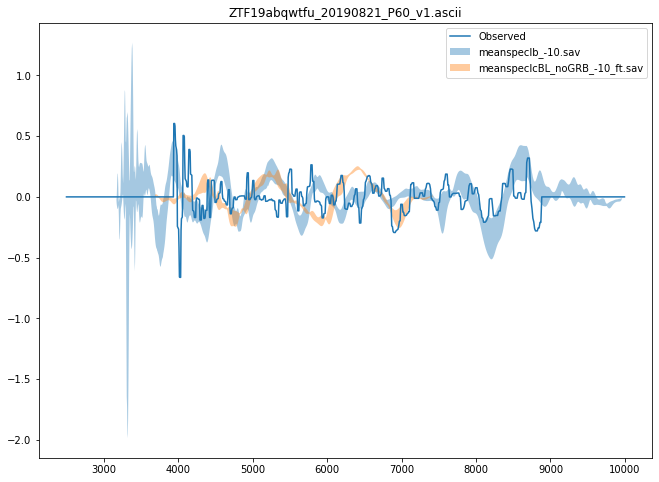

In [113]:
plt.figure(figsize=(11,8))
plot_observed(0, smooth=5)
plot_template('Ib', 'meanspecIb_-10.sav')
plot_template('Ic-BL', 'meanspecIcBL_noGRB_-10_ft.sav')
plt.legend()

(4000.0, 9000.0)

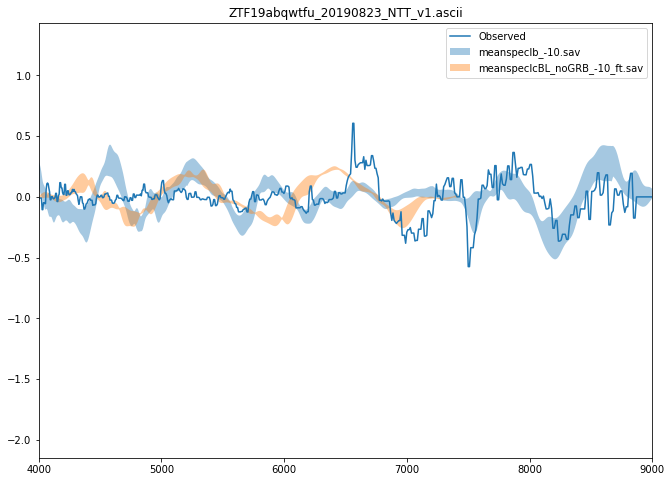

In [177]:
plt.figure(figsize=(11,8))
plot_observed(1, smooth=3)
plot_template('Ib', 'meanspecIb_-10.sav')
plot_template('Ic-BL', 'meanspecIcBL_noGRB_-10_ft.sav')
plt.legend()
plt.xlim((4000,9000))

(4000.0, 9000.0)

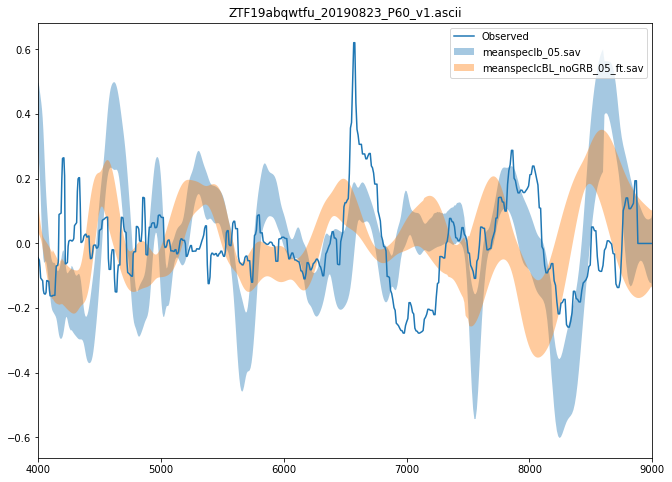

In [187]:
plt.figure(figsize=(11,8))
plot_observed(2, smooth=3)
plot_template('Ib', 'meanspecIb_05.sav')
plot_template('Ic-BL', 'meanspecIcBL_noGRB_05_ft.sav')
plt.legend()
plt.xlim((4000,9000))

(4000.0, 9000.0)

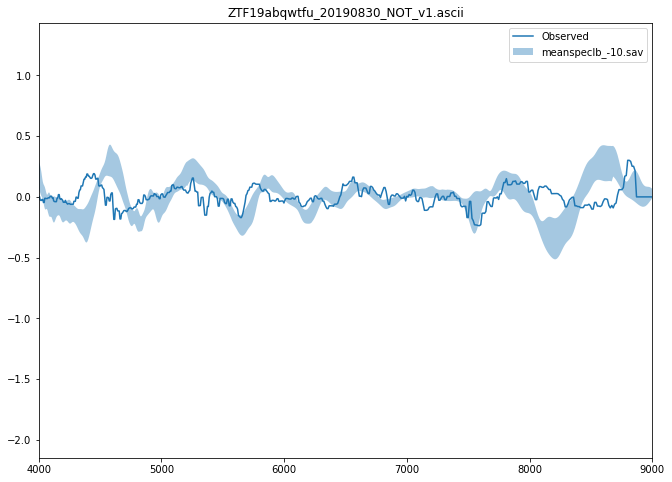

In [192]:
plt.figure(figsize=(11,8))
plot_observed(6, smooth=3)
plot_template('Ib', 'meanspecIb_-10.sav')
#plot_template('Ic-BL', 'meanspecIcBL_noGRB_10_ft.sav')
plt.legend()
plt.xlim((4000,9000))

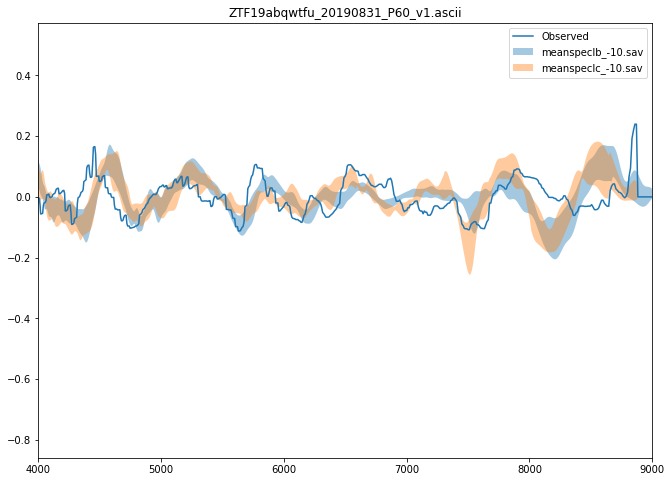

In [203]:
plt.figure(figsize=(11,8))
plot_observed(7, smooth=3)
plot_template('Ib', 'meanspecIb_-10.sav', scale=0.4)
plot_template('Ic', 'meanspecIc_-10.sav', scale=0.5)
#plot_template('Ic-BL', 'meanspecIcBL_noGRB_-10_ft.sav')
plt.legend()
plt.xlim((4000,9000))
plt.savefig('../talks/2021-03-sugroup-meeting/meanspec_7.png')

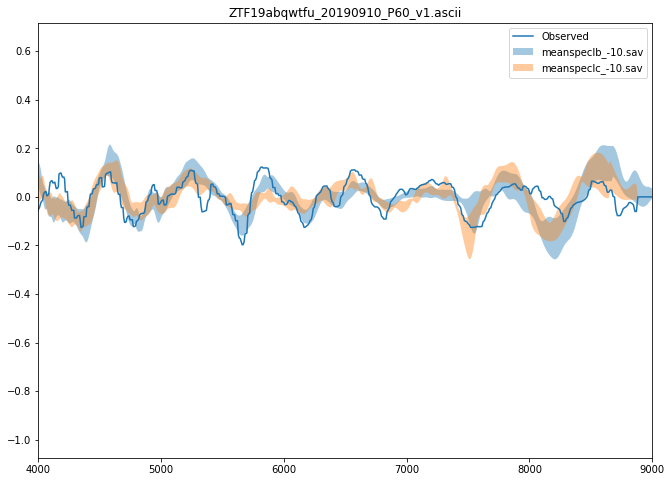

In [206]:
plt.figure(figsize=(11,8))
plot_observed(8, smooth=3)
plot_template('Ib', 'meanspecIb_-10.sav', scale=0.5)
plot_template('Ic', 'meanspecIc_-10.sav', scale=0.5)
#plot_template('Ic-BL', 'meanspecIcBL_noGRB_-10_ft.sav')
plt.xlim((4000,9000))
plt.legend()
plt.savefig('../talks/2021-03-sugroup-meeting/meanspec_8.png')

(4000.0, 9000.0)

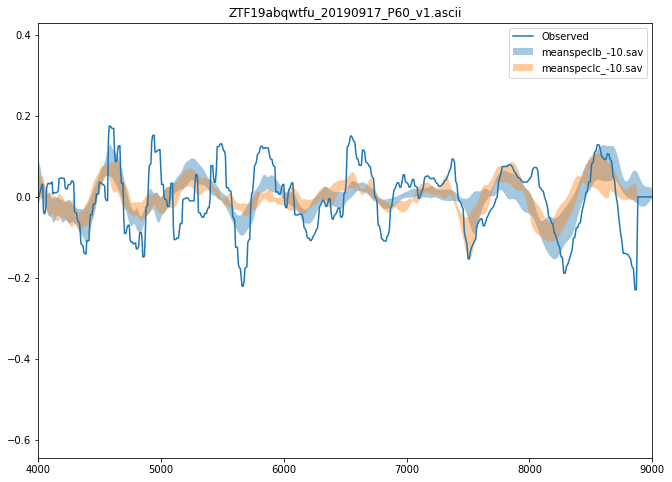

In [207]:
plt.figure(figsize=(11,8))
plot_observed(9, smooth=3)
plot_template('Ib', 'meanspecIb_-10.sav', scale=0.3)
plot_template('Ic', 'meanspecIc_-10.sav', scale=0.3)
#plot_template('Ic-BL', 'meanspecIcBL_noGRB_15_ft.sav', scale=0.8)
plt.legend()
plt.xlim((4000,9000))

(4000.0, 9000.0)

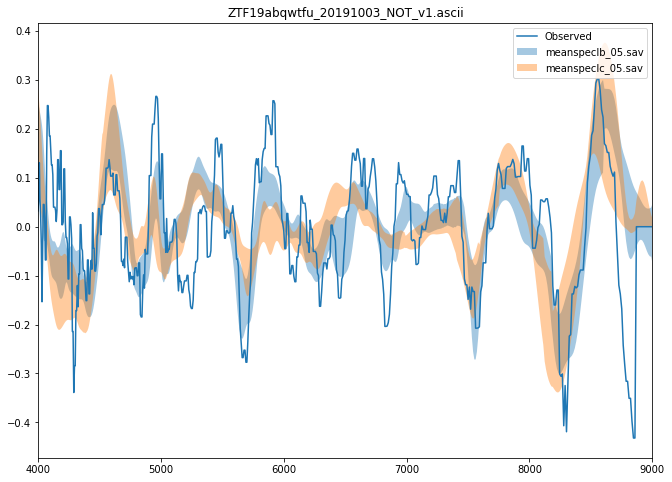

In [168]:
plt.figure(figsize=(11,8))
plot_observed(12, smooth=3)
plot_template('Ib', 'meanspecIb_05.sav', scale=0.5)
plot_template('Ic', 'meanspecIc_05.sav', scale=0.5)
#plot_template('Ic-BL', 'meanspecIcBL_noGRB_-10_ft.sav')
plt.legend()
plt.xlim((4000,9000))

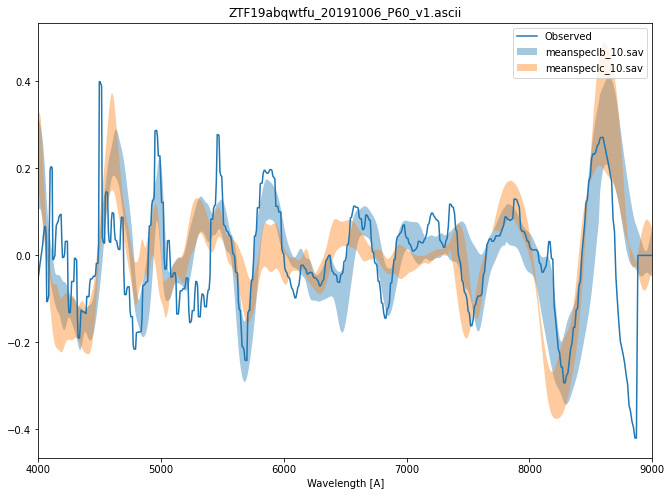

In [208]:
plt.figure(figsize=(11,8))
plot_observed(13, smooth=3)
plot_template('Ib', 'meanspecIb_10.sav', scale=0.5)
plot_template('Ic', 'meanspecIc_10.sav', scale=0.5)
#plot_template('Ic-BL', 'meanspecIcBL_noGRB_35_ft.sav')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.xlim((4000,9000))
plt.savefig('../talks/2021-03-sugroup-meeting/meanspec_13.png')

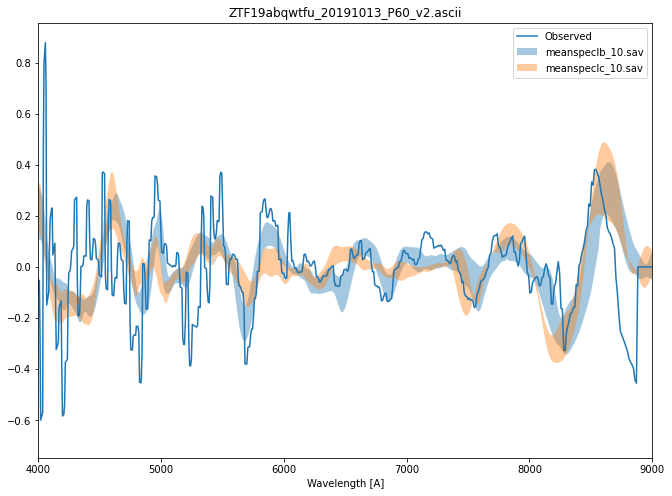

In [209]:
plt.figure(figsize=(11,8))
plot_observed(14)
plot_template('Ib', 'meanspecIb_10.sav', scale=0.5)
plot_template('Ic', 'meanspecIc_10.sav', scale=0.5)
#plot_template('Ic-BL', 'meanspecIcBL_noGRB_-10_ft.sav')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.xlim((4000,9000))
plt.savefig('../talks/2021-03-sugroup-meeting/meanspec_14.png')

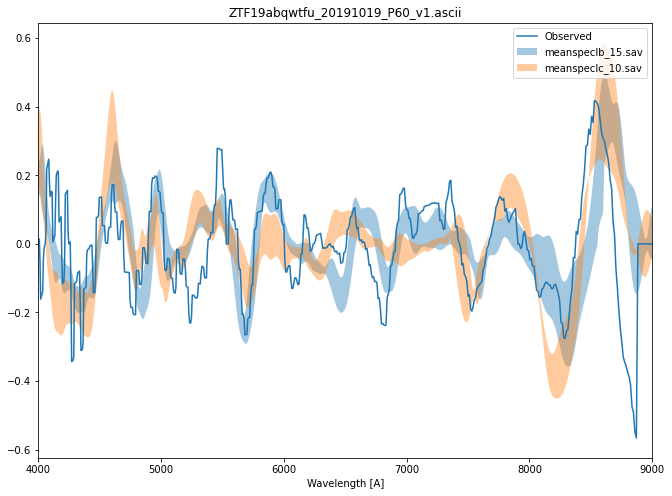

In [210]:
plt.figure(figsize=(11,8))
plot_observed(15)
plot_template('Ib', 'meanspecIb_15.sav', scale=0.5)
plot_template('Ic', 'meanspecIc_10.sav', scale=0.6)
#plot_template('Ic-BL', 'meanspecIcBL_noGRB_25_ft.sav')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.xlim((4000,9000))
plt.savefig('../talks/2021-03-sugroup-meeting/meanspec_15.png')

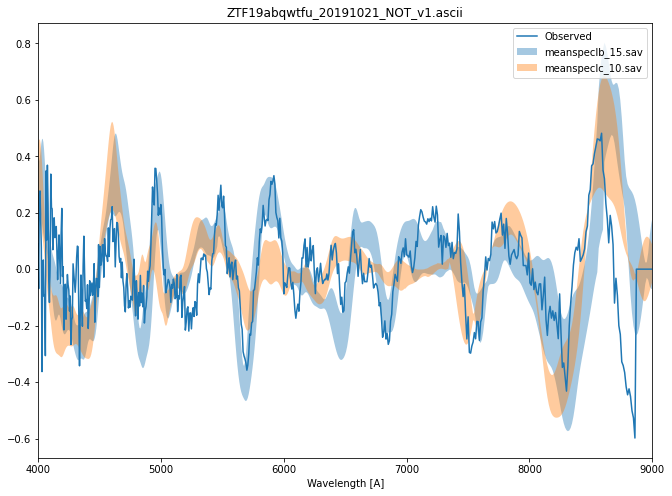

In [211]:
plt.figure(figsize=(11,8))
plot_observed(16)
plot_template('Ib', 'meanspecIb_15.sav', scale=0.8)
plot_template('Ic', 'meanspecIc_10.sav', scale=0.7)
#plot_template('Ic-BL', 'meanspecIcBL_noGRB_30_ft.sav')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.xlim((4000,9000))
plt.savefig('../talks/2021-03-sugroup-meeting/meanspec_16.png')

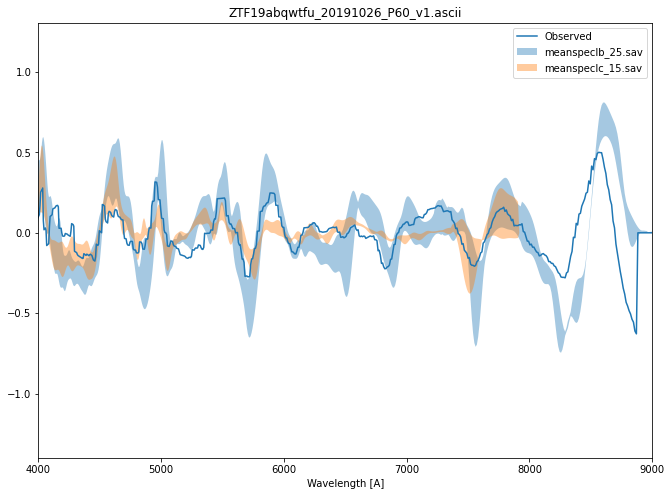

In [212]:
plt.figure(figsize=(11,8))
plot_observed(17)
plot_template('Ib', 'meanspecIb_25.sav', scale=1.0)
plot_template('Ic', 'meanspecIc_15.sav', scale=0.6)
#plot_template('Ic-BL', 'meanspecIcBL_noGRB_30_ft.sav')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.xlim((4000,9000))
plt.savefig('../talks/2021-03-sugroup-meeting/meanspec_17.png')

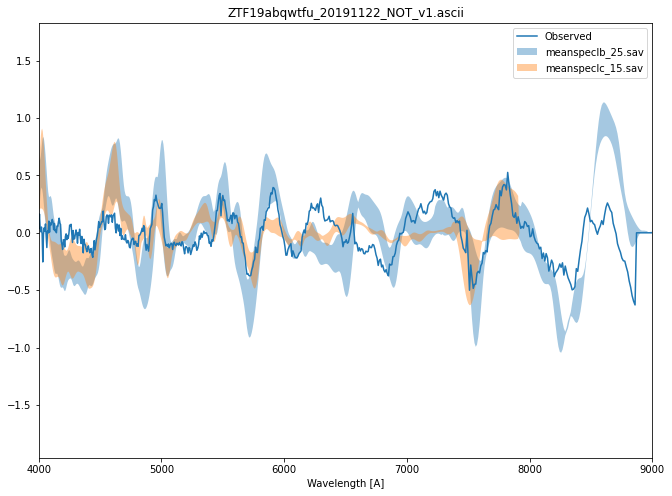

In [213]:
plt.figure(figsize=(11,8))
plot_observed(20)
plot_template('Ib', 'meanspecIb_25.sav', scale=1.4)
plot_template('Ic', 'meanspecIc_15.sav', scale=1.0)
#plot_template('Ic-BL', 'meanspecIcBL_noGRB_30_ft.sav')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.xlim((4000,9000))
plt.savefig('../talks/2021-03-sugroup-meeting/meanspec_20.png')

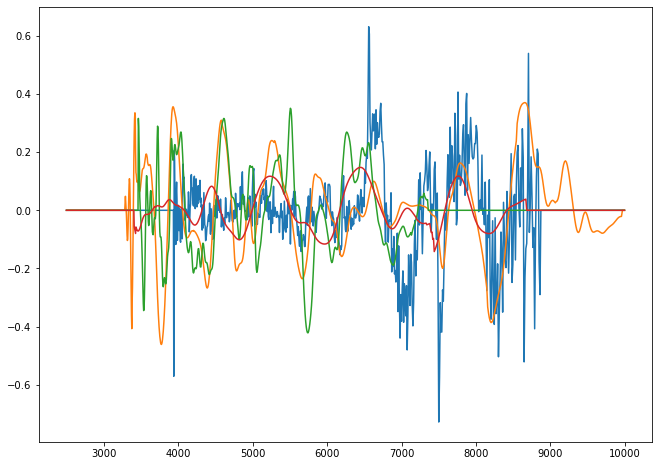

In [57]:
plt.figure(figsize=(11,8))
plot_observed(25)
plot_template('Ib', 'meanspecIb_-05.sav')
plot_template('Ic', 'meanspecIb_-05.sav')
plot_template('Ic-BL', 'meanspecIcBL_noGRB_-05_ft.sav')

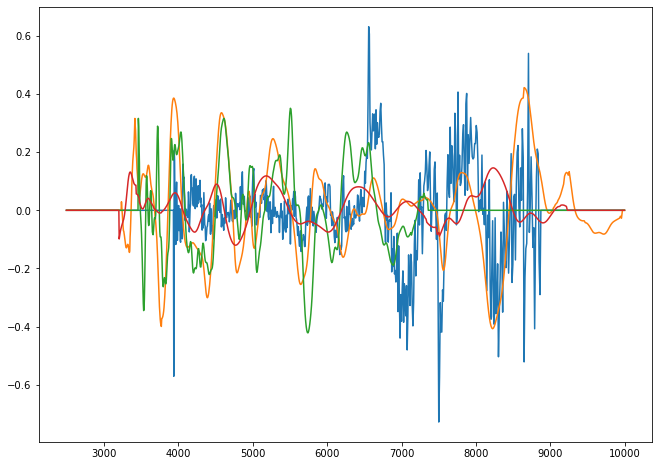

In [58]:
plt.figure(figsize=(11,8))
plot_observed(25)
plot_template('Ib', 'meanspecIb_00.sav')
plot_template('Ic', 'meanspecIb_00.sav')
plot_template('Ic-BL', 'meanspecIcBL_noGRB_00_ft.sav')

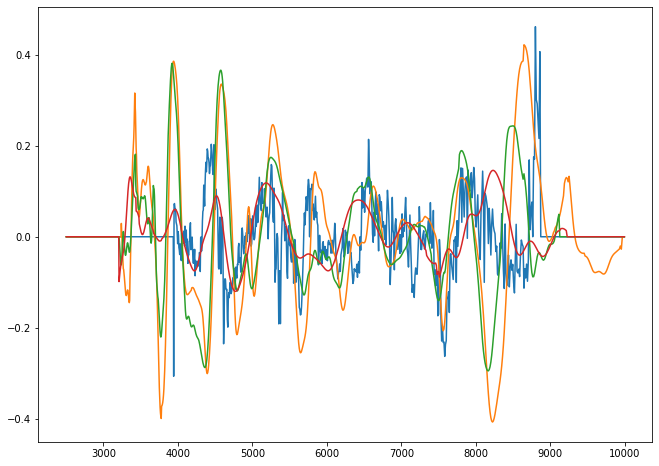

In [11]:
plt.figure(figsize=(11,8))
plot_observed(6)
plot_template('Ib', 'meanspecIb_00.sav')
plot_template('Ic', 'meanspecIb_00.sav')
plot_template('Ic-BL', 'meanspecIcBL_noGRB_00_ft.sav')